In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
import boto3
from tqdm import tqdm
import geopandas
from tensorflow import keras

# 1. Data Collection

## 1.1 Download files from s3 'nyc-tlc bucket

In [2]:
# Skip this cell if all files have already been saved in './data' folder.
os.makedirs('./data', exist_ok=True)
s3 = boto3.resource('s3')
s3.Object('nyc-tlc', 'misc/taxi _zone_lookup.csv').download_file('./data/taxi+_zone_lookup.csv')
s3.Object('nyc-tlc', 'misc/taxi_zones.zip').download_file('./data/taxi_zones.zip')
with zipfile.ZipFile("./data/taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./data/taxi_zones")
# Only use yellow taxi data between 2018~2019(Jan to June) in Manhattan for the demo solution
for year in [2018, 2019]:
    for month in range(1, 7):
        name = 'yellow_tripdata_{}-{:02d}.csv'.format(year, month)
        print('download {}...'.format(name))
        s3.Object('nyc-tlc', 'trip data/{}'.format(name)).download_file('./data/{}'.format(name))

## 1.2 Prepare data for data explore

In [3]:
# load zone info files
zone_lookup = pd.read_csv('./data/taxi+_zone_lookup.csv')
location_id_in_manhattan = zone_lookup[zone_lookup['Borough']=='Manhattan']['LocationID'].values
taxi_zones = geopandas.read_file('./data/taxi_zones/taxi_zones.shp')
manhattan_zones = taxi_zones[taxi_zones['LocationID'].isin(location_id_in_manhattan)]

In [4]:
# load one csv for EDA
year_to_explore = 2018
month_to_explore = 1
location_to_explore = 79
data = pd.read_csv('./data/yellow_tripdata_{}-{:02d}.csv'.format(year_to_explore, month_to_explore))

In [5]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


In [6]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')

Field Name|Description|
:---|:---|
VendorID|A code indicating the TPEP provider that provided the record.<br><br>1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.|
tpep_pickup_datetime|The date and time when the meter was engaged.|
tpep_dropoff_datetime|The date and time when the meter was disengaged.|
passenger_count|The date and time when the meter was disengaged.<br><br>This is a driver-entered value.|
trip_distance|The elapsed trip distance in miles reported by the taximeter.|
RatecodeID|The final rate code in effect at the end of the trip.<br><br>1=Standard rate<br>2=JFK<br>3=Newark<br>4=Nassau or Westchester<br>5=Negotiated fare<br>6=Group ride|
store_and_fwd_flag|This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.<br><br>Y= store and forward trip<br>N= not a store and forward trip|
PULocationID|TLC Taxi Zone in which the taximeter was engaged|
DOLocationID|TLC Taxi Zone in which the taximeter was disengaged|
payment_type|A numeric code signifying how the passenger paid for the trip.<br>1= Credit card<br>2= Cash<br>3= No charge<br>4= Dispute<br>5= Unknown<br>6= Voided trip|
fare_amount|The time-and-distance fare calculated by the meter.|
extra|Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and $1 rush hour and overnight charges.|
mta_tax|\$0.50 MTA tax that is automatically triggered based on the metered rate in use.|
tip_amount|Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.|
tolls_amount|Total amount of all tolls paid in trip.|
improvement_surcharge|\$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.|
total_amount|The total amount charged to passengers. Does not include cash tips.|

In [7]:
print(data.shape)

(8759874, 17)


# 2. Data cleaning & Basic EDA

## 2.1 Drop pickup not happened in Manhattan

In [8]:
data.drop(data[data["PULocationID"].isin(location_id_in_manhattan) == False].index, inplace=True)
print('Data shape after dropping: {}'.format(data.shape))

Data shape after dropping: (7965703, 17)


In [9]:
# Nan Check
data.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

## 2.2 Creating new Dataframe with extra data columns

In [10]:
def timeToUnix(t):
    return time.mktime(datetime.strptime(t, "%Y-%m-%d %H:%M:%S").timetuple())
    
def dfWithExapndColumns(df, year, month):
    startTime = datetime.now()
    # original columns
    new_frame = df[['tpep_pickup_datetime', 'PULocationID','DOLocationID', 'passenger_count','total_amount','trip_distance']]
    # trip duration in minutes
    pickup_time = [timeToUnix(pkup) for pkup in df["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in df["tpep_dropoff_datetime"].values]
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time)) / float(60)
    new_frame["trip_duration"] = trip_duration
    # weekend or holiday info
    new_frame['is_weekend'] = ((pd.DatetimeIndex(df['tpep_pickup_datetime']).dayofweek) // 5 == 1).astype(int)
    # day of week
    new_frame['day_of_week'] = pd.DatetimeIndex(df['tpep_pickup_datetime']).dayofweek
    # Time-binning in 5,15,30 minutes
    start_pickup_unix = time.mktime(datetime(year, month, 1).timetuple())
    binned_5min = [(int((i-start_pickup_unix)/300)) for i in pickup_time]
    # binned_15min = [(int((i-start_pickup_unix)/900)) for i in pickup_time]
    # binned_30min = [(int((i-start_pickup_unix)/1800)) for i in pickup_time]
    new_frame['pickup_bins_5min'] = np.array(binned_5min)
    # new_frame['pickup_bins_15min'] = np.array(binned_15min)
    # new_frame['pickup_bins_30min'] = np.array(binned_30min)
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return new_frame

In [11]:
new_data = dfWithExapndColumns(data, year_to_explore, month_to_explore)

Time taken for creation of dataframe is 0:02:37.374605


In [12]:
new_data.head()

,tpep_pickup_datetime,PULocationID,DOLocationID,passenger_count,total_amount,trip_distance,trip_duration,is_weekend,day_of_week,pickup_bins_5min
0,2018-01-01 00:21:05,41,24,1,5.80,0.5,3.300000,0,0,4
1,2018-01-01 00:44:55,239,140,1,15.30,2.7,18.166667,0,0,8
2,2018-01-01 00:08:26,262,141,2,8.30,0.8,5.916667,0,0,1
3,2018-01-01 00:20:22,140,257,1,34.80,10.2,32.483333,0,0,4
4,2018-01-01 00:09:18,246,239,2,16.55,2.5,17.800000,0,0,1


## 2.3 Outlier check: Trip Durations  

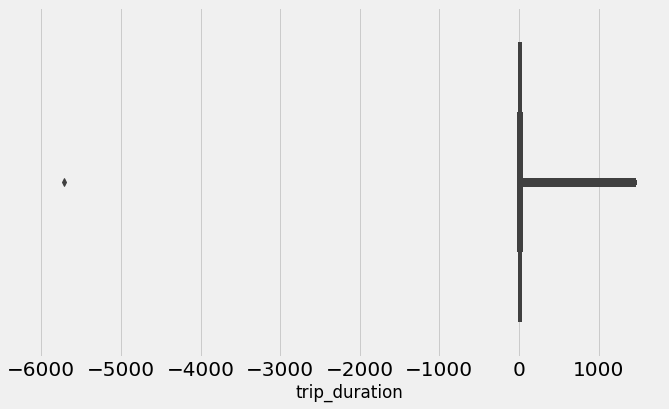

In [13]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = new_data)
plt.tick_params(labelsize = 20)
plt.show()

In [14]:
# describe after drop trip_duration < 0 or > 24 hours
new_data.drop(new_data[(new_data["trip_duration"]<0)|(new_data["trip_duration"]>1440)].index, inplace=True)
pd.set_option('display.float_format',lambda x : '%.2f' % x)
new_data['trip_duration'].describe()

count   7965702.00
mean         14.49
std          59.25
min           0.00
25%           6.10
50%           9.93
75%          15.65
max        1439.98
Name: trip_duration, dtype: float64

Most people in Manhattan usually takes less than 16 minutes(75%) for one trip.

## 2.4 Outlier check: Trip Distance

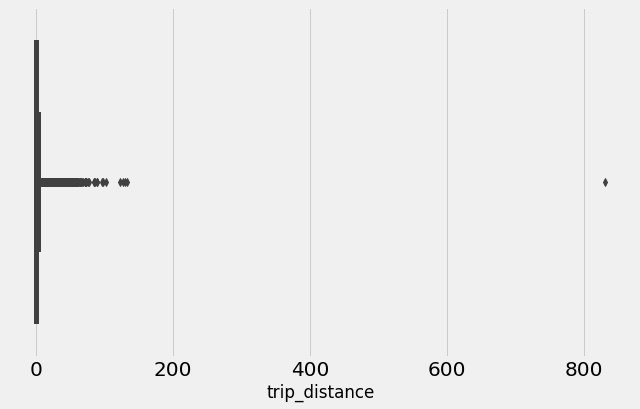

In [15]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = new_data)
plt.tick_params(labelsize = 20)
plt.show()

In [16]:
# describe after drop trip_distance > 200 miles
new_data.drop(new_data[(new_data["trip_distance"]>200)].index, inplace=True)
new_data['trip_distance'].describe()

count   7965701.00
mean          2.23
std           2.53
min           0.00
25%           0.90
50%           1.48
75%           2.50
max         132.61
Name: trip_distance, dtype: float64

We can see that most trip is short distance(75% < 2.5 miles).

## 2.5 Explore the relationship between workday and weekend

In [17]:
# Prepare data for exploring
frame_group_all = new_data.groupby(['PULocationID'], as_index=False).size()
frame_group_workday = new_data[new_data['is_weekend']==0].groupby(['PULocationID'], as_index=False).size()
frame_group_weekend = new_data[new_data['is_weekend']==1].groupby(['PULocationID'], as_index=False).size()

frame_group_all.rename(columns={'PULocationID': 'LocationID', 'size': 'DemandCount'}, inplace=True)
frame_group_workday.rename(columns={'PULocationID': 'LocationID', 'size': 'DemandCount'}, inplace=True)
frame_group_weekend.rename(columns={'PULocationID': 'LocationID', 'size': 'DemandCount'}, inplace=True)

frame_group_all['DemandCount'] = frame_group_all['DemandCount'].apply(lambda x: x / 31)
frame_group_workday['DemandCount'] = frame_group_workday['DemandCount'].apply(lambda x: x / 23)
frame_group_weekend['DemandCount'] = frame_group_weekend['DemandCount'].apply(lambda x: x / 8)

frame_group_diff = frame_group_workday.merge(frame_group_weekend, on = 'LocationID', how = 'left')
frame_group_diff['DemandCount'] = frame_group_diff['DemandCount_x'] - frame_group_diff['DemandCount_y']
frame_group_diff = frame_group_diff.merge(manhattan_zones, on = 'LocationID', how = 'left')
frame_group_diff['DemandArea'] = frame_group_diff['LocationID'].astype(str) + '.' + frame_group_diff['zone']

frame_group_all = geopandas.GeoDataFrame(frame_group_all)
frame_group_workday = geopandas.GeoDataFrame(frame_group_workday)
frame_group_weekend = geopandas.GeoDataFrame(frame_group_weekend)

frame_group_all = frame_group_all.merge(manhattan_zones, on = 'LocationID', how = 'left')
frame_group_workday = frame_group_workday.merge(manhattan_zones, on = 'LocationID', how = 'left')
frame_group_weekend = frame_group_weekend.merge(manhattan_zones, on = 'LocationID', how = 'left')

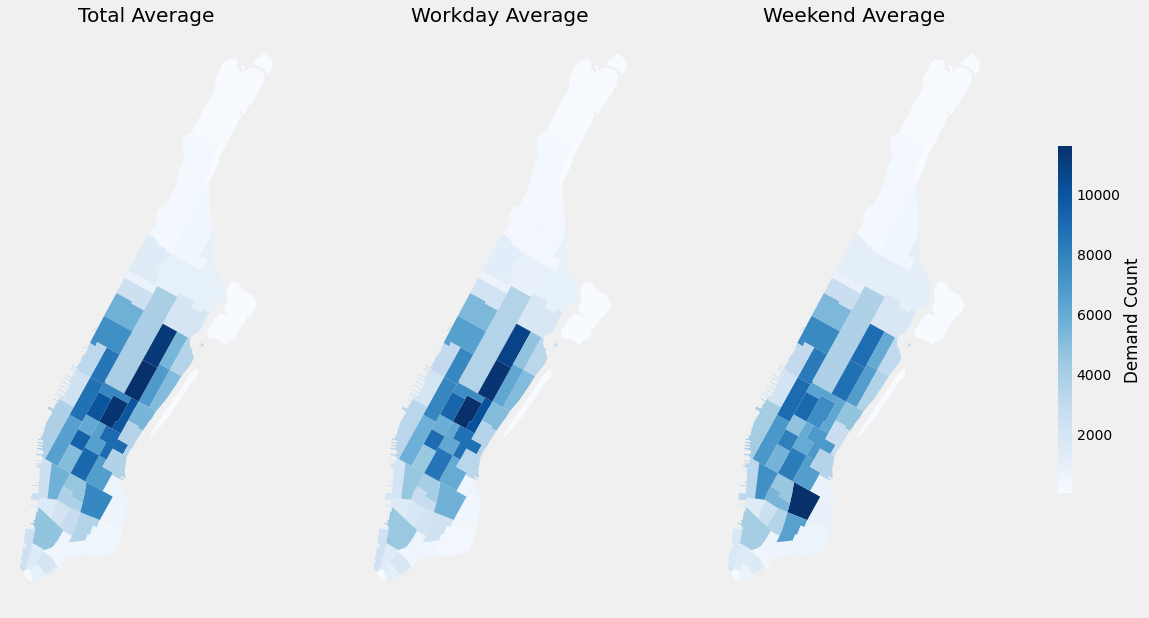

In [18]:
# Plot daily average damand
fig, axes = plt.subplots(1,3, figsize=(20,10), sharex=True, sharey=True, subplot_kw=dict(aspect='equal'))
axes[0].set_title('Total Average')
axes[0].xaxis.set_major_locator(plt.NullLocator())
axes[0].yaxis.set_major_locator(plt.NullLocator())
axes[1].set_title('Workday Average')
axes[1].xaxis.set_major_locator(plt.NullLocator())
axes[1].yaxis.set_major_locator(plt.NullLocator())
axes[2].set_title('Weekend Average')
axes[2].xaxis.set_major_locator(plt.NullLocator())
axes[2].yaxis.set_major_locator(plt.NullLocator())
frame_group_all.plot('DemandCount', k=4, cmap=plt.cm.Blues, alpha=1.0, ax=axes[0])
frame_group_workday.plot('DemandCount', k=4, cmap=plt.cm.Blues, alpha=1.0, ax=axes[1])
frame_group_weekend.plot('DemandCount', k=4, cmap=plt.cm.Blues, alpha=1.0, ax=axes[2])
fig.colorbar(axes[0].collections[0], ax=axes, shrink=0.6, label='Demand Count')

<BarContainer object of 67 artists>

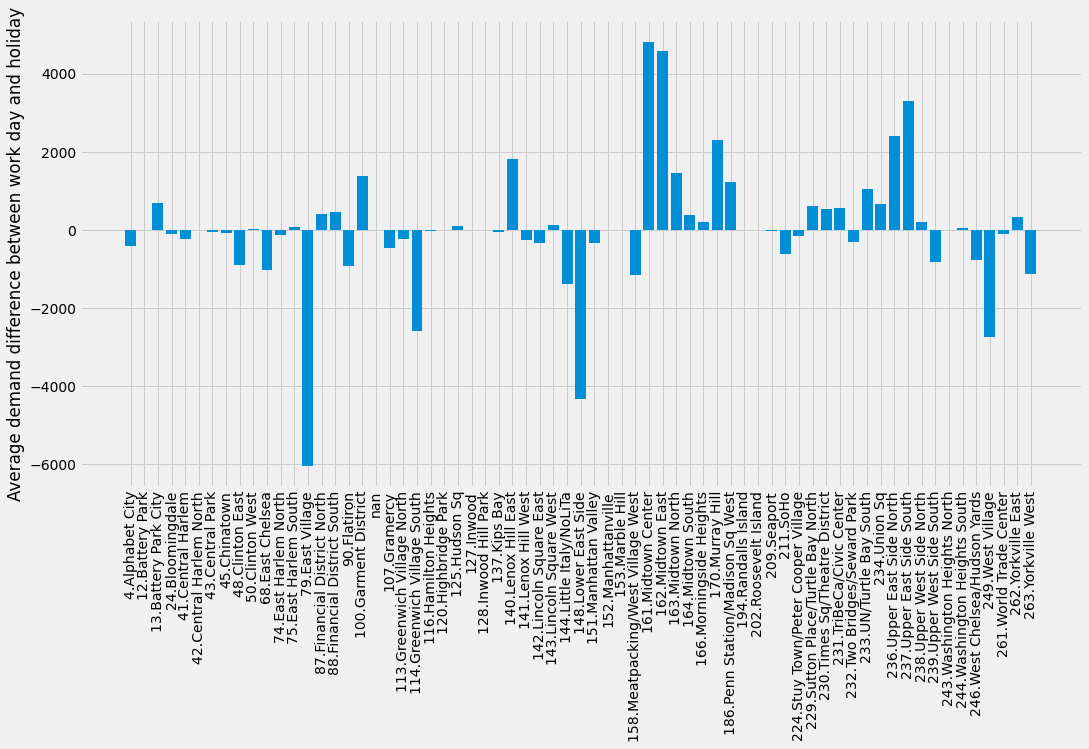

In [19]:
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(frame_group_diff)), frame_group_diff['DemandArea'], rotation='vertical')
plt.ylabel('Average demand difference between work day and holiday')
plt.bar(np.arange(len(frame_group_diff)), frame_group_diff['DemandCount'])

In some areas such as '79.East Village' and '148.Lower East Side', workday damand is significantly lower than weekend.
In contrast, areas such as '161.Midtown Center' and '162.Midtown East' workday damand is significantly higher than weekend.

## 2.6 Explore the relationship between demand and day of week

<BarContainer object of 7 artists>

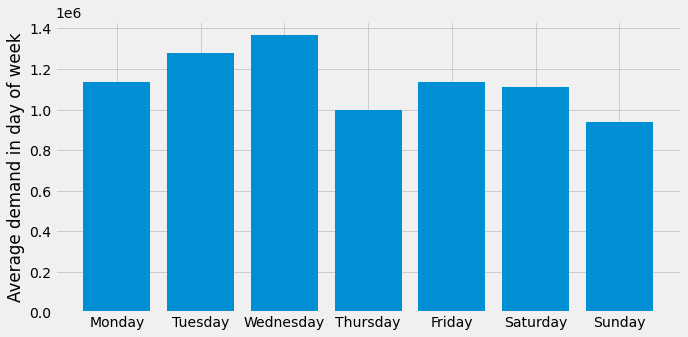

In [20]:
frame_group_week = new_data.groupby(['day_of_week'], as_index=False).size()
plt.figure(figsize=(10,5))
plt.xticks(np.arange(len(frame_group_week)), calendar.day_name)
plt.ylabel('Average demand in day of week')
plt.bar(np.arange(len(frame_group_week)), frame_group_week['size'])

## 2.6 Explore the change in demand over time

In [21]:
# Group by location and time bin
frame_group = new_data[['PULocationID', 'pickup_bins_5min', 'trip_distance']].groupby(['PULocationID', 'pickup_bins_5min'])
df_gb = frame_group.size()

In [22]:
def fillZeroBins(bin_serial, year, month, duraion):
    zeroFilled = []
    total_bin = int(calendar.monthrange(year, month)[1] * 24 * 60 / duraion)  # duraion is in minute
    for n_bin in range(total_bin):
        if n_bin in bin_serial.index:
            zeroFilled.append(bin_serial[n_bin])
        else:
            zeroFilled.append(0)
    return zeroFilled

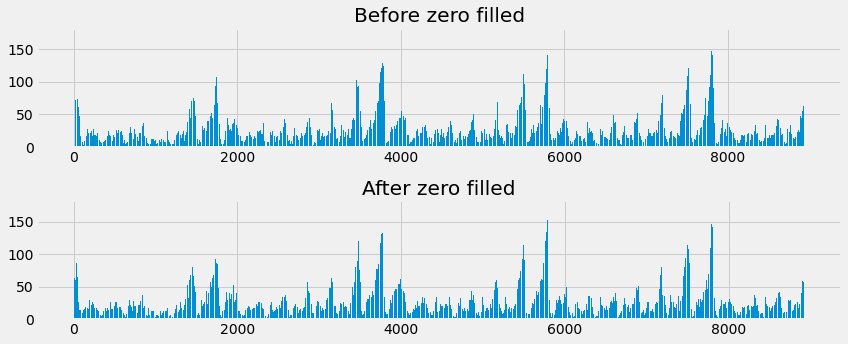

In [23]:
# Plot 5min binned demand bar in one month
location_before = df_gb.loc[(location_to_explore,)].values
location_after = fillZeroBins(df_gb.loc[(location_to_explore,)], year_to_explore, month_to_explore, 5)
plt.figure(figsize=(12,5))
plt.subplot(2, 1, 1)
plt.title('Before zero filled')
plt.bar(np.arange(len(location_before)), location_before)
plt.subplot(2, 1, 2)
plt.title('After zero filled')
plt.bar(np.arange(len(location_after)), location_after)
plt.tight_layout()

# 3. Task Definition
## Time-series forecasting and Regression
* To find a number of pickups in each location at 5min,15min and 30min slot.
* To solve the above we use yellow taxi data in 2018/1 ~ 2019/3 for training, and 2019/4~2019/6 for testing.

## 3.1 Create dataset

In [25]:
# All data is loaded to memory for convenience, this can be done in a machine with 16GB memory.
X_train = []
Y_train = []
X_test = []
Y_test = []
window_len = 42
for year in [2018, 2019]:
    for month in range(1, 7):
        print('='*50)
        print('len of X_train:{} before'.format(len(X_train)))
        print('len of Y_train:{} before'.format(len(Y_train)))
        
        print('loading data for {}-{:02d}...'.format(year, month))
        data = pd.read_csv('./data/yellow_tripdata_{}-{:02d}.csv'.format(year, month))
        print('{} loaded. '.format(len(data)))

        # Nan Check
        data.isnull().sum()
        
        print('Dropping data not in Manhattan...')
        data.drop(data[data["PULocationID"].isin(location_id_in_manhattan) == False].index, inplace=True)
        print('{} after drop. '.format(len(data)))
        
        print('Dropping trip_distance> 200 miles...')
        data.drop(data[(data["trip_distance"]>200)].index, inplace=True)
        print('{} after drop. '.format(len(data)))
        
        print('Expanding data...')
        new_data = dfWithExapndColumns(data, year, month)
        
        print('Dropping trip_duration < 0 or > 24 hours...')
        new_data.drop(new_data[(new_data["trip_duration"]<0)|(new_data["trip_duration"]>1440)].index, inplace=True)
        print('{} after drop. '.format(len(new_data)))
        
        print('Preparing time bin data...')
        frame_group = new_data[['PULocationID', 'pickup_bins_5min', 'trip_distance']].groupby(['PULocationID', 'pickup_bins_5min'])
        df_gb = frame_group.size()
        for location_id in location_id_in_manhattan:
            if (location_id,) in df_gb.keys():
                location_data = fillZeroBins(df_gb.loc[(location_id,)], year, month, 5)
                ser_data = pd.Series(location_data)
                data = ser_data.rolling(window=window_len)
                for window in data:
                    v = window.values
                    if len(v) == window_len and np.sum(v[:-6]) > 3:
                        # Train Data: 2018/1~2019/3
                        # Test Data: 2019/4~2019/6
                        if year == 2019 and month > 3:
                            X_test.append(v[:-6])
                            Y_test.append([v[-6], np.sum(v[-6:-4]), np.sum(v[-6:])])
                        else:
                            X_train.append(v[:-6])
                            Y_train.append([v[-6], np.sum(v[-6:-4]), np.sum(v[-6:])])

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True)
X_train = np.expand_dims(np.asarray(X_train), axis=-1)
Y_train = np.expand_dims(np.asarray(Y_train), axis=-1)
X_valid = np.expand_dims(np.asarray(X_valid), axis=-1)
Y_valid = np.expand_dims(np.asarray(Y_valid), axis=-1)
X_test = np.expand_dims(np.asarray(X_test), axis=-1)
Y_test = np.expand_dims(np.asarray(Y_test), axis=-1)
print('----Dataset Summary----')
print('Train Data Len: {}, Validate Data Len: {}, Test Data Len: {}'.format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))
print('----Dataset Summary----')

len of X_train:0 before
len of Y_train:0 before
loading data for 2018-01...
8759874 loaded. 
Dropping data not in Manhattan...
7965703 after drop. 
Dropping trip_distance> 200 miles...
7965702 after drop. 
Expanding data...
Time taken for creation of dataframe is 0:02:40.300665
Dropping trip_duration < 0 or > 24 hours...
7965701 after drop. 
Preparing time bin data...
len of X_train:531426 before
len of Y_train:531426 before
loading data for 2018-02...
8492076 loaded. 
Dropping data not in Manhattan...
7767881 after drop. 
Dropping trip_distance> 200 miles...
7767878 after drop. 
Expanding data...
Time taken for creation of dataframe is 0:02:35.777532
Dropping trip_duration < 0 or > 24 hours...
7767875 after drop. 
Preparing time bin data...
len of X_train:1012384 before
len of Y_train:1012384 before
loading data for 2018-03...
9430376 loaded. 
Dropping data not in Manhattan...
8568668 after drop. 
Dropping trip_distance> 200 miles...
8568666 after drop. 
Expanding data...
Time taken f

In [26]:
# Metrics: RMSE and MAE
def print_metrics(y_labels, y_preds):
#     labels = scaler_Y.inverse_transform(np.squeeze(y_labels))
#     preds = scaler_Y.inverse_transform(np.squeeze(y_preds))
    labels = np.squeeze(y_labels)
    preds = np.squeeze(y_preds)
    # RMSE
    RMSE_overall = np.sqrt(mean_squared_error(labels, preds))
    RMSE_5min = np.sqrt(mean_squared_error(labels[:,0], preds[:,0]))
    RMSE_15min = np.sqrt(mean_squared_error(labels[:,1], preds[:,1]))
    RMSE_30min = np.sqrt(mean_squared_error(labels[:,2], preds[:,2]))
    print('RMSE : Overall={:.02f} 5min={:.02f} 15min={:.02f} 30min={:.02f}'.
          format(RMSE_overall, RMSE_5min, RMSE_15min, RMSE_30min))
    # MAE
    MAE_overall = mean_absolute_error(labels, preds)
    MAE_5min = mean_absolute_error(labels[:,0], preds[:,0])
    MAE_15min = mean_absolute_error(labels[:,1], preds[:,1])
    MAE_30min = mean_absolute_error(labels[:,2], preds[:,2])
    print('MAE  : Overall={:.02f} 5min={:.02f} 15min={:.02f} 30min={:.02f}'.
          format(MAE_overall, MAE_5min, MAE_15min, MAE_30min))

In [27]:
def plot_result(y_labels, y_preds, plot_len=1000):
    plt.figure(figsize=(10,8))
    plt.subplot(3, 1, 1)
    plt.title('Result of 5min prediction')
    plt.plot(np.arange(0, plot_len), y_labels[:plot_len,0], color='green', linewidth=2)
    plt.plot(np.arange(0, plot_len), y_preds[:plot_len,0], color='blue', linewidth=2)
    plt.subplot(3, 1, 2)
    plt.title('Result of 15min prediction')
    plt.plot(np.arange(0, plot_len), y_labels[:plot_len,1], color='green', linewidth=2)
    plt.plot(np.arange(0, plot_len), y_preds[:plot_len,1], color='blue', linewidth=2)
    plt.subplot(3, 1, 3)
    plt.title('Result of 30min prediction')
    plt.plot(np.arange(0, plot_len), y_labels[:plot_len,2], color='green', linewidth=2)
    plt.plot(np.arange(0, plot_len), y_preds[:plot_len,2], color='blue', linewidth=2)
    plt.tight_layout()

## 3.2 LSTM Model

In [28]:
model_lstm = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=[36, 1]),
    keras.layers.LSTM(32),
    keras.layers.Dense(3)
])
model_lstm.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(0.001))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_lstm.fit(X_train, Y_train, epochs=10, verbose=2, validation_data=(X_valid, Y_valid))

Epoch 1/10
131211/131211 - 613s - loss: 306.1104 - val_loss: 190.8953
Epoch 2/10
131211/131211 - 611s - loss: 184.2479 - val_loss: 181.0759
Epoch 3/10
131211/131211 - 608s - loss: 181.5856 - val_loss: 178.7694
Epoch 4/10
131211/131211 - 611s - loss: 180.6352 - val_loss: 181.1119
Epoch 5/10
131211/131211 - 640s - loss: 179.1791 - val_loss: 177.7940
Epoch 6/10
131211/131211 - 639s - loss: 178.8905 - val_loss: 179.4898
Epoch 7/10
131211/131211 - 642s - loss: 178.6067 - val_loss: 175.5308
Epoch 8/10
131211/131211 - 640s - loss: 178.4258 - val_loss: 177.0096
Epoch 9/10
131211/131211 - 648s - loss: 178.8506 - val_loss: 176.9997
Epoch 10/10
131211/131211 - 662s - loss: 179.0069 - val_loss: 176.3864


In [32]:
Y_pred = model_lstm.predict(X_test)
print_metrics(Y_test, Y_pred)

RMSE : Overall=11.95 5min=4.25 15min=7.06 30min=18.98
MAE  : Overall=6.33 5min=2.79 15min=4.52 30min=11.68


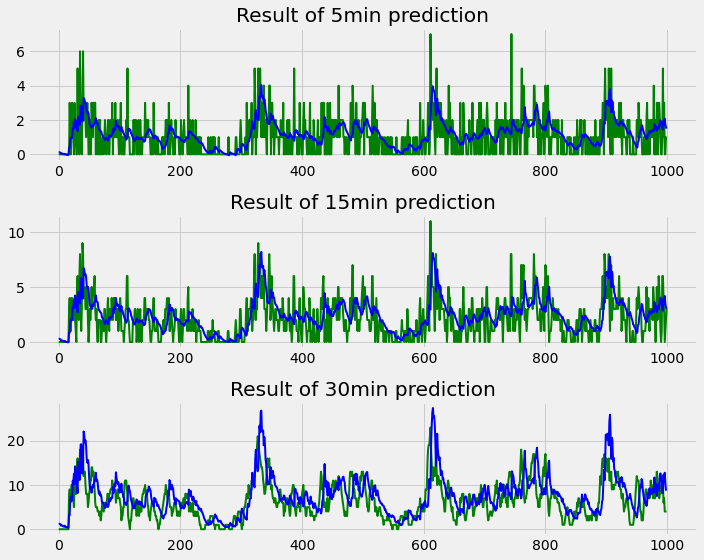

In [33]:
# See the first 1000 prediction results
plot_result(Y_test, Y_pred)